h values used: [0.05       0.025      0.0125     0.00625    0.003125   0.0015625
 0.00078125 0.00039063 0.00019531]
Exact solution at x = 1.5: tan(1.5) = 14.10141995

Error table:
h              Euler_value     Euler_error     RK4_value      RK4_error
  0.05000000     6.28364241     7.818×10⁰    14.07013099    3.129×10⁻²
  0.02500000     8.18565265     5.916×10⁰    14.09885512    2.565×10⁻³
  0.01250000    10.06144157     4.040×10⁰    14.10124388    1.761×10⁻⁴
  0.00625000    11.60675625     2.495×10⁰    14.10140864    1.131×10⁻⁵
  0.00312500    12.68208355     1.419×10⁰    14.10141924    7.117×10⁻⁷
  0.00156250    13.33800960    7.634×10⁻¹    14.10141990    4.454×10⁻⁸
  0.00078125    13.70449804    3.969×10⁻¹    14.10141994    2.784×10⁻⁹
  0.00039063    13.89889442    2.025×10⁻¹    14.10141995   1.737×10⁻¹⁰
  0.00019531    13.99910568    1.023×10⁻¹    14.10141995   1.109×10⁻¹¹

Euler method:
  best (h=1.95e-04)              y_best                  = 13.99910568
  second-best (h=3.91e-

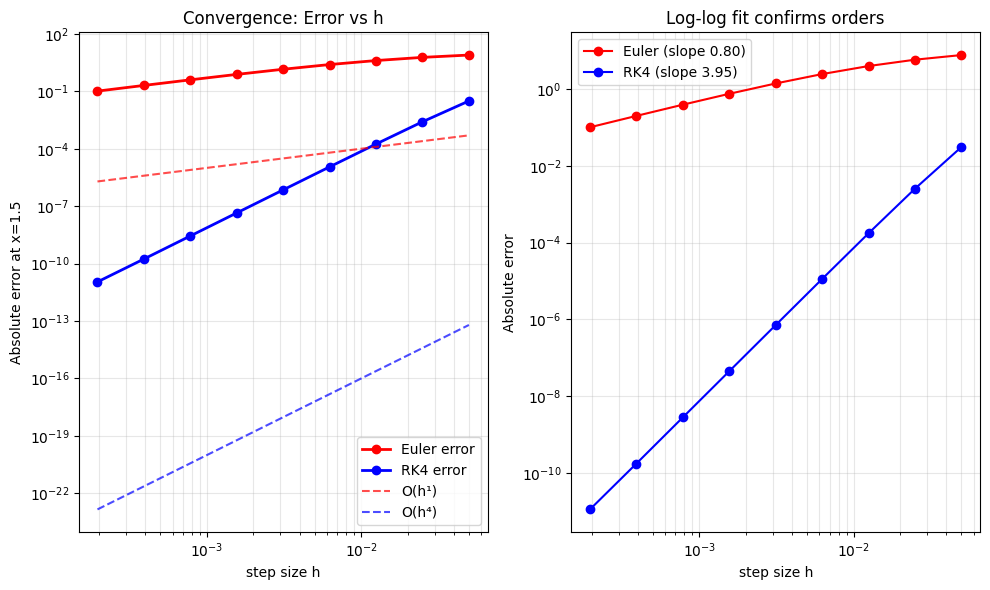


Plot saved as 'convergence_analysis.png'
Log-log slopes confirm: Euler p≈0.80, RK4 p≈3.95


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

# ANSI color codes
RED   = "\033[31m"
BLUE  = "\033[34m"
GREEN = "\033[32m"
YEL   = "\033[33m"
RESET = "\033[0m"

# helper: scientific notation with Unicode superscript exponent
_sup_map = str.maketrans({
    "-": "⁻",
    "0": "⁰",
    "1": "¹",
    "2": "²",
    "3": "³",
    "4": "⁴",
    "5": "⁵",
    "6": "⁶",
    "7": "⁷",
    "8": "⁸",
    "9": "⁹",
})

def sci_sup(x, digits=3):
    """Return string like 3.347×10⁻⁴."""
    if x == 0:
        return f"{0:.{digits}f}×10⁰"
    exp = int(np.floor(np.log10(abs(x))))
    mant = x / 10**exp
    exp_str = str(exp).translate(_sup_map)
    return f"{mant:.{digits}f}×10{exp_str}"

# ODE and exact solution
def f(x, y):
    return y**2 + 1

def exact_solution(x):
    return np.tan(x)

def euler(f, x0, y0, h, x_end):
    N = int((x_end - x0) / h)
    xs = np.linspace(x0, x_end, N+1)
    ys = np.zeros(N+1)
    ys[0] = y0
    for n in range(N):
        ys[n+1] = ys[n] + h * f(xs[n], ys[n])
    return xs, ys

def rk4(f, x0, y0, h, x_end):
    N = int((x_end - x0) / h)
    xs = np.linspace(x0, x_end, N+1)
    ys = np.zeros(N+1)
    ys[0] = y0
    for n in range(N):
        x, y = xs[n], ys[n]
        k1 = f(x, y)
        k2 = f(x + 0.5*h, y + 0.5*h*k1)
        k3 = f(x + 0.5*h, y + 0.5*h*k2)
        k4 = f(x + h,     y + h*k3)
        ys[n+1] = y + (h/6.0)*(k1 + 2*k2 + 2*k3 + k4)
    return xs, ys

# ---------- Convergence with same step sizes ----------
x0, y0 = 0.0, 0.0
x_end = 1.5

# SAME step sizes: 0.05, 0.025, ..., 0.05/2^8 = 0.05/256 ≈ 0.000195
hs = 0.05 / (2.0 ** np.arange(0, 9))
print(f"{GREEN}h values used:{RESET}", hs)

y_true = exact_solution(x_end)
print(f"{GREEN}Exact solution at x = {x_end}: tan({x_end}) = {y_true:.8f}{RESET}")

# Store ALL results
all_valsE = []
all_valsR = []

print(f"\n{YEL}Error table:{RESET}")
print(f"{YEL}h              Euler_value     Euler_error     RK4_value      RK4_error{RESET}")
for i, h in enumerate(hs):
    _, yE = euler(f, x0, y0, h, x_end)
    _, yR = rk4(f, x0, y0, h, x_end)
    
    valE, valR = yE[-1], yR[-1]
    errE, errR = abs(valE - y_true), abs(valR - y_true)
    
    all_valsE.append(valE)
    all_valsR.append(valR)
    
    print(
        f"{h:12.8f}   "
        f"{RED}{valE:12.8f}  {sci_sup(errE):>12}{RESET}   "
        f"{BLUE}{valR:12.8f}  {sci_sup(errR):>12}{RESET}"
    )

all_valsE = np.array(all_valsE)
all_valsR = np.array(all_valsR)
errE = abs(all_valsE - y_true)
errR = abs(all_valsR - y_true)

# --- Simple uncertainty / error reporting (no Richardson) ---
for name, vals, errs, color in [
    ("Euler", all_valsE, errE, RED),
    ("RK4",   all_valsR, errR, BLUE),
]:
    best       = vals[-1]      # finest-grid value
    second     = vals[-2]      # second-fine value
    finest_err = errs[-1]      # absolute error vs exact at finest grid
    finest_frac_err = abs(best - y_true) / abs(y_true)
    frac_two   = abs(best - second) / abs(best)  # fractional diff between two finest grids

    print(f"\n{color}{name} method:{RESET}")
    print(f"{color}  best (h={hs[-1]:.2e})              y_best                  = {best:.8f}{RESET}")
    print(f"{color}  second-best (h={hs[-2]:.2e})      y_2nd                   = {second:.8f}{RESET}")
    print(f"{color}  ABSOLUTE difference (finest vs exact) = {finest_err:.6e}{RESET}")
    print(f"{color}  fractional error (finest vs exact)   = {finest_frac_err:.6e}{RESET}")
    print(f"{color}  fractional diff (two finest grids)   = {frac_two:.6e}   (uncertainty proxy){RESET}")

# Log-log convergence plot
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
plt.loglog(hs, errE, 'ro-', label='Euler error', linewidth=2, markersize=6)
plt.loglog(hs, errR, 'bo-', label='RK4 error', linewidth=2, markersize=6)

# Reference lines for expected orders
h_ref = np.logspace(np.log10(hs.min()), np.log10(hs.max()), 50)
plt.loglog(h_ref, 1e-2 * h_ref**1, 'r--', alpha=0.7, label='O(h¹)')
plt.loglog(h_ref, 1e-8 * h_ref**4, 'b--', alpha=0.7, label='O(h⁴)')

plt.xlabel('step size h')
plt.ylabel('Absolute error at x=1.5')
plt.title('Convergence: Error vs h')
plt.grid(True, which='both', alpha=0.3)
plt.legend()

# Log-log slope plot (order confirmation)
plt.subplot(1, 2, 2)
pE, _ = np.polyfit(np.log(hs), np.log(errE), 1)
pR, _ = np.polyfit(np.log(hs), np.log(errR), 1)

plt.loglog(hs, errE, 'ro-', label=f'Euler (slope {pE:.2f})')
plt.loglog(hs, errR, 'bo-', label=f'RK4 (slope {pR:.2f})')
plt.xlabel('step size h')
plt.ylabel('Absolute error')
plt.title('Log-log fit confirms orders')
plt.grid(True, which='both', alpha=0.3)
plt.legend()

plt.tight_layout()
plt.savefig("convergence_analysis.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"\n{GREEN}Plot saved as 'convergence_analysis.png'{RESET}")
print(f"{GREEN}Log-log slopes confirm: Euler p≈{pE:.2f}, RK4 p≈{pR:.2f}{RESET}")
